- title: "Differential Protein Expression"
- author: "Margaret Paiva"
- author: "Gilad Silberberg"
- date: "2021/12/21"
- output: R notebook

In [1]:
# cran packages
x <- c('dplyr',
       'data.table',
       'tidyr',   
       'tidyverse', 
       'ggplot2', 
       'viridis')
# bioconductor packages
y <- c('DEP', 
       'SummarizedExperiment')

In [2]:
# # install bioconductor packages
# if (!requireNamespace("BiocManager", quietly=TRUE))
#     install.packages("BiocManager")
# BiocManager::install(y)

In [3]:
# # install cran packages
# for (pkg in x) {
#     if (!pkg %in% rownames(installed.packages())) {install.packages(pkg)}
# }

In [4]:
# load packages
load_lib <- function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
}
invisible(lapply(c(x, y), load_lib)) # remove invisible() to see which packages are loaded

## Data

The SummarizedExperiment object has a couple of specifications. The log2-transformed assay data and the specified rowData and colData columns are prerequisites for the subsequent analysis steps.
- The assay data is log2-transformed. 
- Its rownames depict the protein/gene names. The rowData contains, amongst others, the ‘name’ and ‘ID’ columns.
- The colData contains the experimental design and thereby the sample annotation. Thereby the colData includes the ‘label’, ‘condition’ and ‘replicate’ columns as well as a newly generated ‘ID’ column.  

In [5]:
data <- readRDS('./data/AMLproteomics_imp_norm_se_list2021-04-06.rds')
data <- data$conservative  # choose conservative or lenient
colData(data) <- subset(colData(data), select = -c(condition, replicate)) 
names(colData(data))[names(colData(data)) == 'Treatment.history'] <- 'condition'
colData(data)$replicate <- colData(data)$ID   

In [6]:
# This is the annotated data formate (SummarizedExperiment object) in R
# equivalent to AnnData in Python
data

class: SummarizedExperiment 
dim: 2885 46 
metadata(0):
assays(1): ''
rownames(2885): A2M A8MWD9 ... ZW10 ZYX
rowData names(6): hgnc_symbol ProteinGroupId ... imputed num_NAs
colnames(46): CTG_2226 CTG_2227 ... CTG_3679 CTG_3680
colData names(25): ID model_id ... label replicate

In [7]:
# assay data
dim(assay(data))
head(assay(data), 2)

[1] 2885   46

,CTG_2226,CTG_2227,CTG_2228,CTG_2229,CTG_2232,CTG_2233,CTG_2234,CTG_2235,CTG_2236,CTG_2238,...,CTG_3659,CTG_3660,CTG_3661,CTG_3663,CTG_3667,CTG_3670,CTG_3673,CTG_3674,CTG_3679,CTG_3680
A2M,15.386,15.65601,16.38401,14.84999,15.84399,13.96596,13.74704,12.77808,14.961,16.10501,...,14.16703,14.633,14.19599,14.85599,18.291,16.511,16.103,13.30307,16.764,14.975
A8MWD9,18.122,18.84500,18.90100,19.04300,18.11900,18.30000,18.77900,18.71000,19.251,18.82300,...,18.22900,18.100,18.99500,18.63300,18.498,18.798,18.729,18.82300,18.432,18.730


In [8]:
# row info
dim(rowData(data))
head(as.data.frame(rowData(data)), 1)

[1] 2885    6

,hgnc_symbol,ProteinGroupId,ID,name,imputed,num_NAs
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
A2M,A2M,P01023,P01023,A2M,FALSE,0


In [9]:
# col info
dim(colData(data))
head(as.data.frame(colData(data)), 1)

[1] 46 25

,ID,model_id,Age,BCR.ABL.status,CD34.status,Cytogenetics,Diagnosis,Ethnicity,FAB.classification.WHO.subtype,FLT3.status,...,Model.status,NPM.status,Platelet.count..x103.ml.,Sample.source,condition,Tumor.type,TumorGraft.ID,White.blood.cell.count..x109.L.,label,replicate
,<chr>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>,<fct>,...,<fct>,<chr>,<fct>,<fct>,<chr>,<fct>,<fct>,<dbl>,<chr>,<chr>
CTG_2226,CTG_2226,2226,52,NA,CD34-,"46, XY, ADD(6)(P21), DEL(8)(P21), ADD(12)(Q24.1) [13]/46, XY, DEL(1)(Q32), DEL(7)(Q22Q32), DER(6;12)(Q10;P10), ADD(22)(Q11.2), +MAR [3]/45, XY, T(1;2)(P22;Q11.2), -21 [1]/46, XY [3]",REFRACTORY,CAUCASIAN,M4 (MYELOMONOCYTIC),ITD MUTANT,...,ESTABLISHED,WILD TYPE,23,LEUKAPHERESIS,PRETREATED,ACUTE MYELOID LEUKEMIA (AML),NA,113,CTG_2226,CTG_2226


In [10]:
# summary of pretreated vs. naive
table(colData(data)$condition, useNA = "always")


     NAIVE PRETREATED       <NA> 
        15         29          2 

## Processing

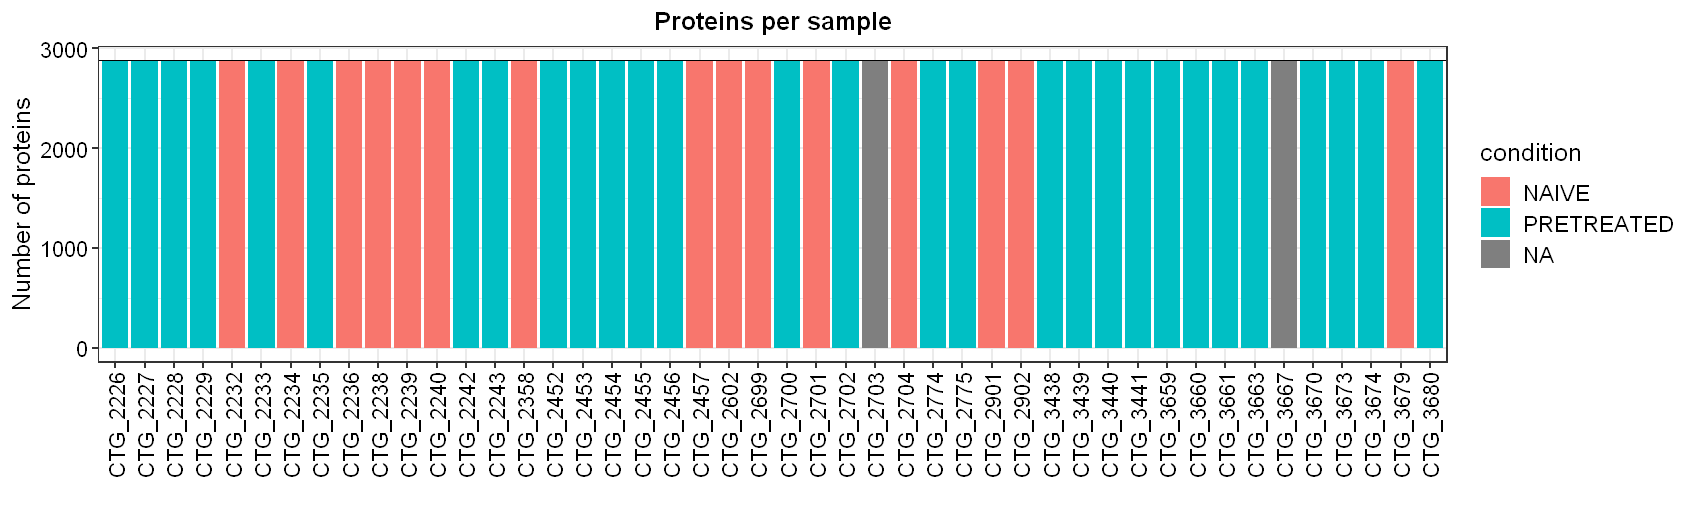

In [28]:
# Plot a barplot of the number of identified proteins per samples
options(repr.plot.width=13, repr.plot.height=4, repr.plot.res=130)
plot_numbers(data)

This is because this data set has been imputed or filtered to have no missing proteins per sample

In [12]:
# Normalize the data
data_norm <- normalize_vsn(data)

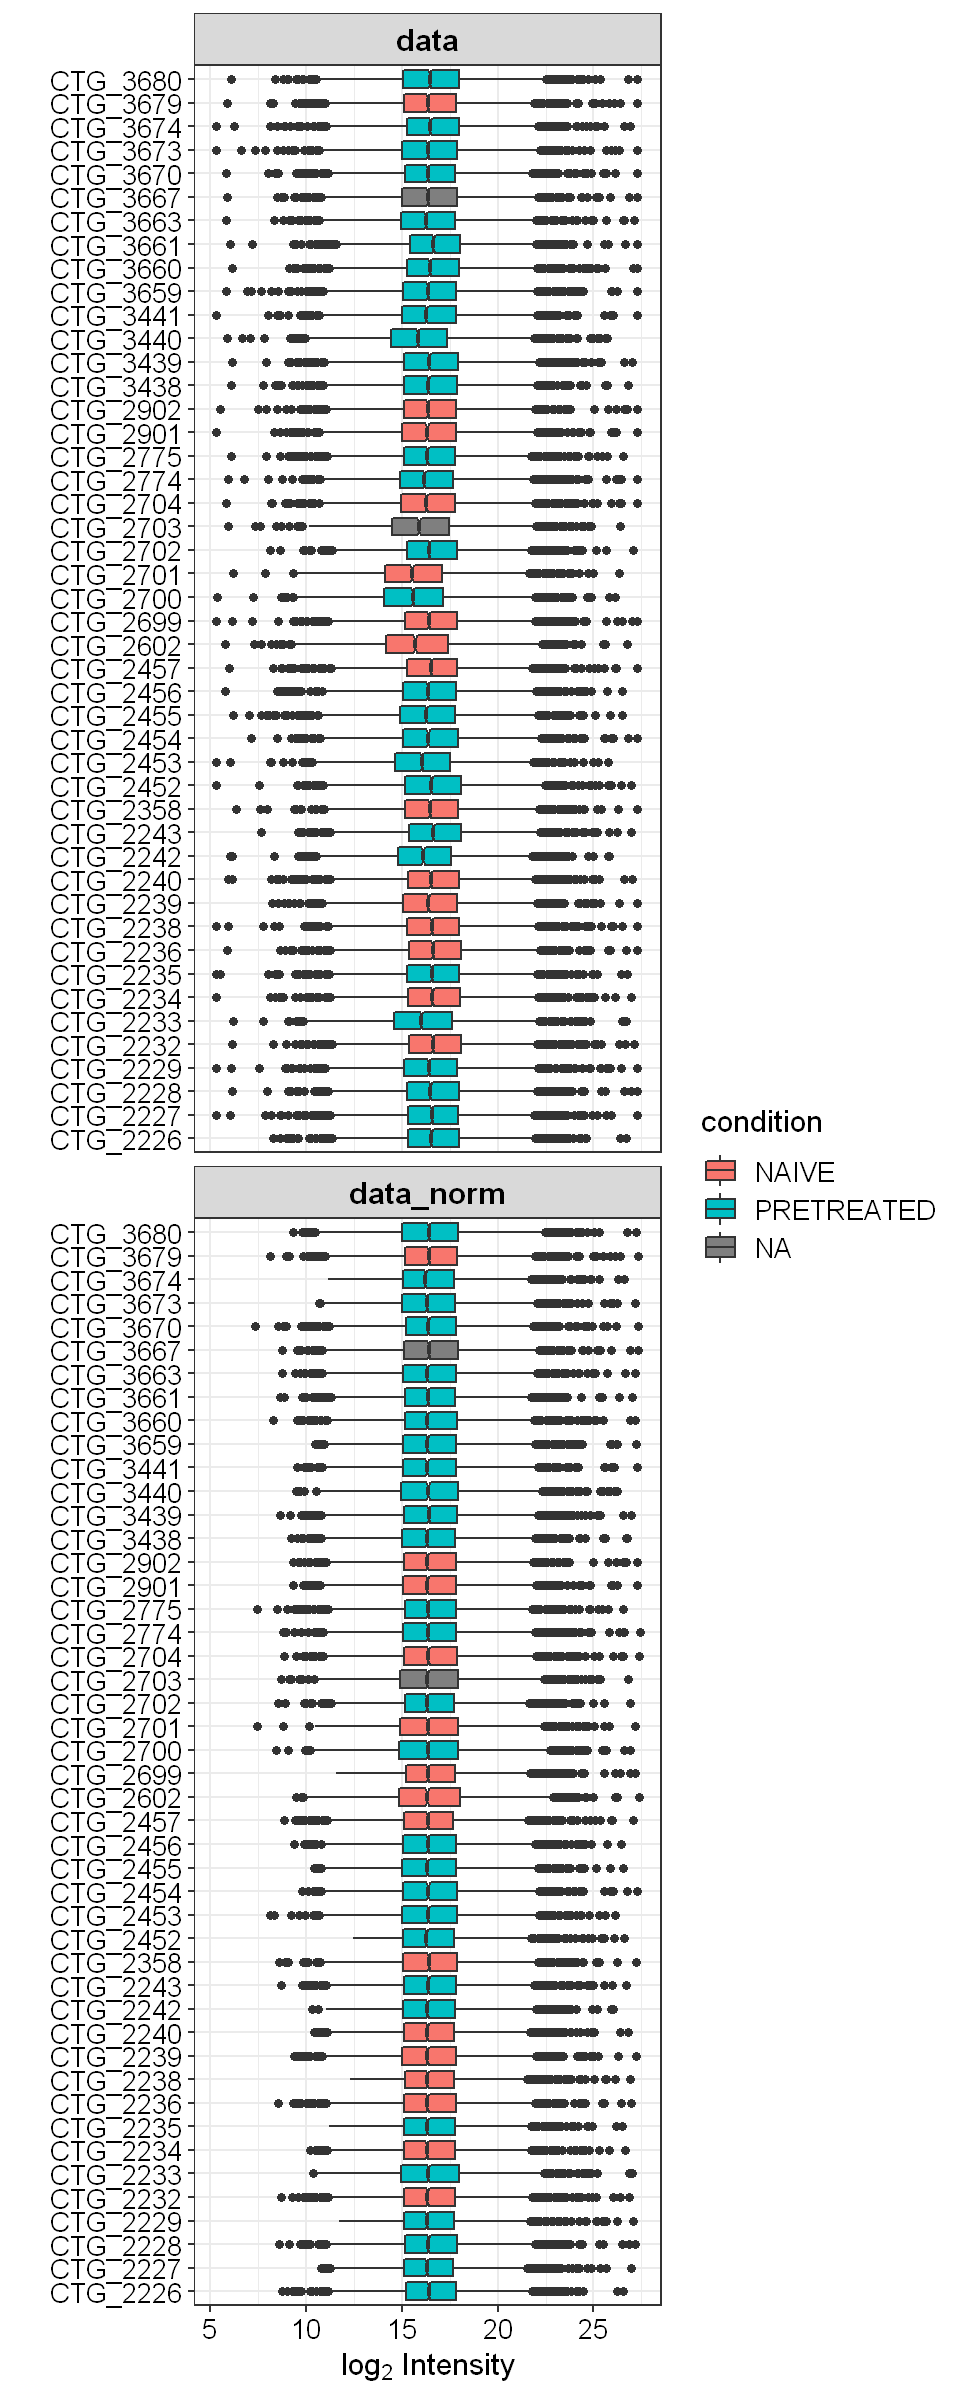

In [39]:
# Visualize normalization by boxplots for all samples before and after normalization
options(repr.plot.width=6, repr.plot.height=15, repr.plot.res=160)
plot_normalization(data, data_norm)

After normalization, the data are median centered. 

## Differential enrichment analysis

In [40]:
# Test treated sample versus naive
data_diff <- test_diff(data_norm, type = "control", control = "NAIVE")

Tested contrasts: PRETREATED_vs_NAIVE, NA_vs_NAIVE



ERROR: Error in lmFit(raw, design = design): row dimension of design doesn't match column dimension of data object


## Example

In [27]:
data <- UbiLength
# We filter for contaminant proteins and decoy database hits, 
# which are indicated by "+" in the columns "Potential.contaminants" and "Reverse", respectively. 
data <- filter(data, Reverse != "+", Potential.contaminant != "+")
head(data, 2)

,Protein.IDs,Majority.protein.IDs,Protein.names,Gene.names,Fasta.headers,Peptides,Razor...unique.peptides,Unique.peptides,LFQ.intensity.Ubi4_1,LFQ.intensity.Ubi4_2,...,LFQ.intensity.Ubi6_3,LFQ.intensity.Ctrl_1,LFQ.intensity.Ctrl_2,LFQ.intensity.Ctrl_3,LFQ.intensity.Ubi1_1,LFQ.intensity.Ubi1_2,LFQ.intensity.Ubi1_3,Only.identified.by.site,Reverse,Potential.contaminant
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9;D6REZ6;D6R9M7;D6RCT1;D6RBP6;D6RA49;D6RFL5;Q5T0W7;Q8TBY0-2;Q8TBY0-3;Q9NQ94-5;Q8TBY0;Q9NQ94-6;Q9NQ94-3;Q9NQ94-2;F8W9F8;Q9NQ94-4;Q9NQ94,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9,RNA-binding protein 47,RBM47,>sp|A0AV96-2|RBM47_HUMAN Isoform 2 of RNA-binding protein 47 OS=Homo sapiens GN=RBM47;>tr|B7Z8Z7|B7Z8Z7_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=2 SV=1;>sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=1 SV=2;>tr|D6R,7,7,7,35787000,24701000,...,32705000,25898000,31275000,23076000,27664000,32314000,31097000,,,
2,A0AVT1;A0AVT1-2;H0Y8S8;A0AVT1-4;A0AVT1-3,A0AVT1;A0AVT1-2,Ubiquitin-like modifier-activating enzyme 6,UBA6,>sp|A0AVT1|UBA6_HUMAN Ubiquitin-like modifier-activating enzyme 6 OS=Homo sapiens GN=UBA6 PE=1 SV=1;>sp|A0AVT1-2|UBA6_HUMAN Isoform 2 of Ubiquitin-like modifier-activating enzyme 6 OS=Homo sapiens GN=UBA6,6,6,6,0,0,...,0,7260800,8612300,7816000,9907700,12387000,9023800,,,


In [48]:
# data %>% group_by(Gene.names) %>% summarize(frequency = n()) %>% 
#   arrange(desc(frequency)) %>% filter(frequency > 1)

In [49]:
# data

In [30]:
# Make unique names using the annotation in the "Gene.names" column 
# as primary names and the annotation in "Protein.IDs" as name 
# for those that do not have an gene name.
data_unique <- make_unique(data, "Gene.names", "Protein.IDs", delim = ";")
head(data_unique, 2)

,Protein.IDs,Majority.protein.IDs,Protein.names,Gene.names,Fasta.headers,Peptides,Razor...unique.peptides,Unique.peptides,LFQ.intensity.Ubi4_1,LFQ.intensity.Ubi4_2,...,LFQ.intensity.Ctrl_2,LFQ.intensity.Ctrl_3,LFQ.intensity.Ubi1_1,LFQ.intensity.Ubi1_2,LFQ.intensity.Ubi1_3,Only.identified.by.site,Reverse,Potential.contaminant,name,ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9;D6REZ6;D6R9M7;D6RCT1;D6RBP6;D6RA49;D6RFL5;Q5T0W7;Q8TBY0-2;Q8TBY0-3;Q9NQ94-5;Q8TBY0;Q9NQ94-6;Q9NQ94-3;Q9NQ94-2;F8W9F8;Q9NQ94-4;Q9NQ94,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9,RNA-binding protein 47,RBM47,>sp|A0AV96-2|RBM47_HUMAN Isoform 2 of RNA-binding protein 47 OS=Homo sapiens GN=RBM47;>tr|B7Z8Z7|B7Z8Z7_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=2 SV=1;>sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=1 SV=2;>tr|D6R,7,7,7,35787000,24701000,...,31275000,23076000,27664000,32314000,31097000,,,,RBM47,A0AV96-2
2,A0AVT1;A0AVT1-2;H0Y8S8;A0AVT1-4;A0AVT1-3,A0AVT1;A0AVT1-2,Ubiquitin-like modifier-activating enzyme 6,UBA6,>sp|A0AVT1|UBA6_HUMAN Ubiquitin-like modifier-activating enzyme 6 OS=Homo sapiens GN=UBA6 PE=1 SV=1;>sp|A0AVT1-2|UBA6_HUMAN Isoform 2 of Ubiquitin-like modifier-activating enzyme 6 OS=Homo sapiens GN=UBA6,6,6,6,0,0,...,8612300,7816000,9907700,12387000,9023800,,,,UBA6,A0AVT1


In [31]:
# Generate a SummarizedExperiment object using an experimental design
LFQ_columns <- grep("LFQ.", colnames(data_unique)) # get LFQ column numbers
experimental_design <- UbiLength_ExpDesign
data_se <- make_se(data_unique, LFQ_columns, experimental_design)

# Generate a SummarizedExperiment object by parsing condition information from the column names
LFQ_columns <- grep("LFQ.", colnames(data_unique)) # get LFQ column numbers
data_se_parsed <- make_se_parse(data_unique, LFQ_columns)

# Let's have a look at the SummarizedExperiment object
data_se

class: SummarizedExperiment 
dim: 2941 12 
metadata(0):
assays(1): ''
rownames(2941): RBM47 UBA6 ... ATXN2.3 X6RHB9
rowData names(13): Protein.IDs Majority.protein.IDs ... name ID
colnames(12): Ubi4_1 Ubi4_2 ... Ubi1_2 Ubi1_3
colData names(4): label ID condition replicate

In [50]:
head(as.data.frame(rowData(data_se)), 2)

,Protein.IDs,Majority.protein.IDs,Protein.names,Gene.names,Fasta.headers,Peptides,Razor...unique.peptides,Unique.peptides,Only.identified.by.site,Reverse,Potential.contaminant,name,ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
RBM47,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9;D6REZ6;D6R9M7;D6RCT1;D6RBP6;D6RA49;D6RFL5;Q5T0W7;Q8TBY0-2;Q8TBY0-3;Q9NQ94-5;Q8TBY0;Q9NQ94-6;Q9NQ94-3;Q9NQ94-2;F8W9F8;Q9NQ94-4;Q9NQ94,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9,RNA-binding protein 47,RBM47,>sp|A0AV96-2|RBM47_HUMAN Isoform 2 of RNA-binding protein 47 OS=Homo sapiens GN=RBM47;>tr|B7Z8Z7|B7Z8Z7_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=2 SV=1;>sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=1 SV=2;>tr|D6R,7,7,7,,,,RBM47,A0AV96-2
UBA6,A0AVT1;A0AVT1-2;H0Y8S8;A0AVT1-4;A0AVT1-3,A0AVT1;A0AVT1-2,Ubiquitin-like modifier-activating enzyme 6,UBA6,>sp|A0AVT1|UBA6_HUMAN Ubiquitin-like modifier-activating enzyme 6 OS=Homo sapiens GN=UBA6 PE=1 SV=1;>sp|A0AVT1-2|UBA6_HUMAN Isoform 2 of Ubiquitin-like modifier-activating enzyme 6 OS=Homo sapiens GN=UBA6,6,6,6,,,,UBA6,A0AVT1


In [35]:
as.data.frame(colData(data_se))

,label,ID,condition,replicate
,<chr>,<chr>,<chr>,<dbl>
Ubi4_1,Ubi4_1,Ubi4_1,Ubi4,1
Ubi4_2,Ubi4_2,Ubi4_2,Ubi4,2
Ubi4_3,Ubi4_3,Ubi4_3,Ubi4,3
Ubi6_1,Ubi6_1,Ubi6_1,Ubi6,1
Ubi6_2,Ubi6_2,Ubi6_2,Ubi6,2
Ubi6_3,Ubi6_3,Ubi6_3,Ubi6,3
Ctrl_1,Ctrl_1,Ctrl_1,Ctrl,1
Ctrl_2,Ctrl_2,Ctrl_2,Ctrl,2
Ctrl_3,Ctrl_3,Ctrl_3,Ctrl,3
